In [2]:
import numpy as np; import pymc3 as pm; import scipy as sc; import matplotlib.pyplot as plt;
import pymongo; nodes = pymongo.MongoClient('hybs.nti.tul.cz').bench.nodes

Mám problémy s návrhem statistického modelu. Nejprve popíšu data, která byla nasbírána.


## Data
Byla nasbírána nějaká data, konkrétněji se jedná od 111 dokumentů. z těch 111 bylo:

- 16 unikátních fyzických strojů 
  - tj. `doom, luna, minos, ...`
- 79 unikátních virtuálních strojů 
 - tj. `doom6.metacentrum.cz, doom28.metacentrum.cz, minos6.zcu.cz, luna37.fzu.cz, ...`

*Nejvíc dat mám pro stroj `luna`, který byl přidělený 24 krát*


### Struktura dokumentu
Každý dokument se může rozdělit na:

 - statická data (jako je velikost keše, frekvence CPU a jiné hardwarové info) ** otázka(1): budou se statická data dále použivat v modelu? **
 - dynamická data (testován výkon stroje), tj. sekce `benchmark`, ta obsahuje
    - čtení, zápis a čtení i zápis z určitého rozsahu paměti (pokud je rozsah paměti malý, bude procesor pracovat s keší l1, pokud se rozsah zvětší bude se používat l2 a následně RAM). Je tedy známo, jak dlouho trval přenos dat ve vymezeném rozsahu paměti pro různé rozsahy paměti
    - propustnost paměti (tentokrát se zvyšuje velikost bufferu)
    - rychlost zápisu souborů

Takhle vypadá profil jednoho stroje

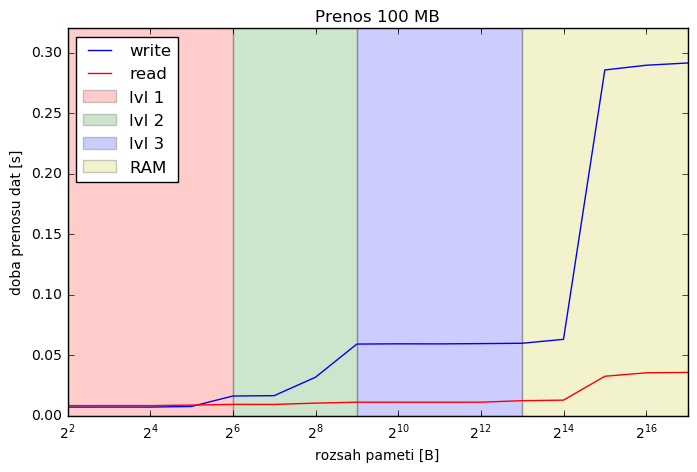

In [7]:
%matplotlib inline
data = nodes.find_one({'machine': 'ida'})
x1 = sorted([int(i) for i in data['benchmark']['cpu']['write']['duration']])
y1 = [data['benchmark']['cpu']['write']['duration'][str(i)] for i in x1]

x2 = sorted([int(i) for i in data['benchmark']['cpu']['read']['duration']])
y2 = [data['benchmark']['cpu']['read']['duration'][str(i)] for i in x2]

plt.figure(figsize=(8, 5))
plt.title('Prenos 100 MB')
plt.semilogx(x1, y1, basex=2, label='write')
plt.semilogx(x2, y2, 'r', basex=2, label='read')
plt.ylim([0, 0.32]); lim = [0, [.32, .32]]
plt.xlabel('rozsah pameti [B]')
plt.ylabel('doba prenosu dat [s]')
plt.fill_between([2**2, 2**6], *lim, alpha=.2, facecolor='r', label="lvl 1")
plt.fill_between([2**6, 2**9], *lim, alpha=.2, facecolor='g', label="lvl 2")
plt.fill_between([2**9, 2**13], *lim, alpha=.2, facecolor='b', label="lvl 3")
plt.fill_between([2**13, 2**17], *lim, alpha=.2, facecolor='y', label="RAM")
plt.legend(loc='upper left');

Ukázka dokumentu z databáze:

```js
{
  "username": "jan-hybs",
  "l1i": 32768,
  "l1d": 32768,
  "l2": 6291456,
  "frequency": 3158.74,
  "hostname": "doom10.metacentrum.cz",
  "hostname_id": 11,
  "machine": "doom",
  "machine_id": 6,
  "x64": true,
  "physical": 8,
  "logical": 2,
  "sockets": 2,
  "benchmark": {
    "io": {
      "cpu": {
        "rw": {
          "size": 1677721600,
          "reps": 3145728,
          "duration": {
            "4": 0.01395278,
            "8": 0.013960759,
            "16": 0.013957598,
                                  # vynechano pro prehlednost #
            "65536": 0.115579959,
            "131072": 0.1170981
          }
        },
        "read": {
          "sum": 451987680,
          "reps": 3145728,
          "size": 104857600,
          "duration": {
            "4": 0.009699557,
            "8": 0.009680459,
            "16": 0.009674691,
                                  # vynechano pro prehlednost #
            "65536": 0.070144328,
            "131072": 0.070030756
          }
        },
        "write": {
          "size": 104857600,
          "reps": 3145728,
          "duration": {
            "4": 0.006980363,
            "8": 0.006977875,
            "16": 0.006975081,
                                  # vynechano pro prehlednost #
            "32768": 0.094968915,
            "65536": 0.095096095,
            "131072": 0.097423918
          }
        },
        "reg": {
          "reps": 314572800,
          "duration": 838852504,
        }
      }
    },
      "band": {
        "size": 25165824,
        "read": {
          "duration": {
            "16": 0.043233191,
            "32": 0.028395117,
            "64": 0.020576427,
            "128": 0.017530017,
                                  # vynechano pro prehlednost #
            "524288": 0.009996271,
            "1048576": 0.010546604
          }
        },
        "write": {
          "duration": {
            "16": 0.062023623,
            "32": 0.045519976,
            "64": 0.036284668,
            "128": 0.03202381,
                                  # vynechano pro prehlednost #
            "524288": 0.021785161,
            "1048576": 0.022432298
          }
        }
      },
      "lat": {
        "del": {
          "duration": 0.013462722
        },
        "read": {
          "duration": 0.008426925
        },
        "write": {
          "duration": 0.056103269
        },
        "count": 1000
      }
    }
}
```

## Statistický model

Nejprve chceme otestovat výpočetní stroje (architektury) a odhadnout jejich parametry. Chceme odhadnout parametry $\alpha_a$ a $\beta_a$ pro architekturu $a$ v modelu (kde vůbec netuším jaké rozdělení použít):

$$
    T_a \sim Normal(\mu_a, \sigma^2)\\
    \mu_a = \alpha_a + \beta_a
$$

kde 

$$
    \alpha \sim\ Normal(0, )\\
    \beta \sim\ Normal(0, ) \\
    \sigma \sim\ Normal(0, )
$$


parametr $\alpha_a$ by nám měl určovat jakýsi parametr "výpočetní výkonnosti" a parametr $\beta_a$ by měl označovat jakýsi parametr "paměťové výkonnosti" pro acrchtekturu $a$.


**A tady začínají pochybnosti...**

Hodnota $T_a$ je doba trvání na architektuře $a$, ale doba trvání čeho? Aby bylo možné natrénovat síť (tím mám na mysli odhadnutí parametrů $\alpha$ a $\beta$) je nutné, hodnoty $T_a$ proti něčemu položit. Řekněme, že mám hodnotu $T_a$ což je nějaká doba trvání. Model řiká, že doba trvání je nějaké normální rozdělení a jeho střed je určen součtem hodnota $\alpha$ a $\beta$, ale už nic neřiká o tom, jak jsou $\alpha$ a $\beta$ zavislé.

Chybí mi tam ta vazba $\alpha \sim $  procesor a $\beta \sim paměť$. Pokud tam ale chceme to vazbu přidat, z jakých dat?

Skoro bych řekl, že tu chybí nějaký program, který když se pustí, bude něco dělat (něco s procesorem nebo něco paměťí, nebo oboje) a vratí nám něco ve smyslu:
```js
{
    "vypocetni-narocnost" x,
    "pametova-narocnost": y
}
```

Bez těchto údajů (s daty které máme) si nědokážu představit/navrhnout model tak, aby to do sebe zapadlo. Nebo druhá možnost, nevidím, která data by se dala použít. Zkoušel jsem hodně modelů za posledních pár dní, ale nic, co by mělo reálný (nebo smysluplný) výsledek.



Takže model, který by mi dável větší smysl bych viděl něco jako:

$$
    T_{a,f} \sim Normal(\mu_{a,f}, \sigma^2)\\
    \mu_{a,f} = \alpha_aP_f + \beta_aM_f
$$

kde $\mu_{a,f}$ je čas běhu programu $f$ na platformě $a$, $\alpha_a$ je pořád to stejné, nějaký neznámý parametr procesorové výkonnosti pro platformu $a$ (obdodbně $\beta_a$), $P_f$ je procesorová náročnost pro program $f$ ( obdobně $M_f$).

To by ale znamenalo, že takový program $f$, zatím nemáme k dispozici a musím ho ještě dodělat (protože nevidím, jaké hodnoty vzít, aby tam nebyla silná závislost na dalších naměřených hodnotách)


Dále netuším, jak do modelu vnést ten parametr $a$, ale to asi už vysvětlím osobně, protože pro kategorizaci tu padlo $Dirichletovo$ rozdělení, o kterém jsem něco málo nastudoval, ale ne tolik, abych to mohl spolehlivě použít v praxi.


** JB poznámky **
- souhlas s druhým modelem
- Je treba ho chapat jako model pro vsechna data. Rekneme ze budeme uvazovat jako odlisne pouze fyzicke architektury, tech je 16. Jako program $f$ je třeba chápat každý rámec, který poskytuje unikátní informaci o času svého běhu, tedy
asi $16*read+16*write+16*rw+16*band+1*reg+3*disk$ tj. celkem 68 "programů". To znamená, že model má $2*16+2*68=168$ parametrů a celkem máš asi 68*111=7548 měření.
- Ovšem programy nejsou moc citlivé na $\beta_a$ a asi bude vhodné vyřadit přístup na disk, protože to nebude asi citlivé ani na jeden parametr architektury.
- Dále se může provést porovnání s modelem s plnou interakcí 68*16 parametrů a tím ověřit kvalitu modelu.
- Lze očekávat, že parametr $\alpha_a$ bude silně korelovat s frekvencí, pokud se to potvrdí i pro reálné programy, tak by se tento parametr mohl přímo počítat ze statických dat.
- Problematický je asi lineární model pro čas paměti. Mezi architekturami se liší velikost cache a asi ne až tolik jejich rychlost. Bylo by lepší uvažovat jako vnitřní parametr programu počet přístupů do paměti v rámci bloku nějaké velikosti, jako bychom např. uvažovali 16 různých cache a počítali kolik přístupů je do které z nich. Obecně budou mít programy asi různé rozdělení, ale dá se předpokládat, že bude hodně přístupů do malých cache a více do velkých. Takže by se možná dal udělat nějaký zjednodušný model pro ty počty, který by měl méně parametrů a pouze by nějak charakterizoval 
daný program. Každopádně pokud pro daný program máme počty přístupů do těch virtuálních cache, tak pro konkrétní architektůru můžeme lépe odhadnout kolik bude přístupů do jednotlivých reálných cache (známe jejich velikost ze statických dat). Pro jednotlivé architektury by se pak fitovaly pouze rychlosti přístupu do cahe.
